In [1]:
import numpy as np

import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.regular as regular


from mlgrad import erm_fg, erm_irgd, fg, weights, averager_it, erisk, sg, erm_sg

#import sklearn.linear_model as sklm
#import sklearn.datasets as datasets

import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])

#plt.style.available

In [2]:
def get_y(lm_line, x):
    return (-lm_line.param[0]-lm_line.param[1]*x)/lm_line.param[2]

In [173]:
def draw_map(lm_line, X, Y, title):
    plt.figure(figsize=(4.5,4.))
    Yp = lm_line.evaluate_all(X)
    plt.title(title)
    plt.minorticks_on()
    X1, X2 = X[:,0], X[:,1]
    plt.scatter(X1, X2, c=Y, s=9, cmap=plt.cm.gray, edgecolors='k', linewidth=0.5)

    x1_min, x1_max = X1.min(), X1.max()
    x2_min, x2_max = X2.min(), X2.max()
    y1_min = get_y(lm_line, x1_min)
    y1_max = get_y(lm_line, x1_max)

    plt.plot([x1_min, x1_max], [y1_min, y1_max], color='k', linewidth=1.0)
    
#     plt.grid(1)
    plt.minorticks_on()
#     plt.xticks([],[])
#     plt.yticks([],[])
#     plt.ylim(-15,15)
    plt.tight_layout()
    #plt.show()

In [176]:
def gendataset(N=300, noise=1, q=0.8):
    X0 = 12*np.random.random(N)-6
    Y0 = 0.5 * X0 + 7.*np.random.random(N)+7
    Z0 = np.ones(N)
    X1 = 12*np.random.random(N)-6
    Y1 = 0.5 * X1 + 7.*np.random.random(N)-7
    Z1 = -np.ones(N)
    if noise:
        M = int(N*q)
#         M2 = M // 2
        X2 = np.random.random(M)
        X2 = 12*(1-X2**0.2) - 6
        Y2 = 0.5 * X2 
        Y2 -= (6-X2)*np.random.random(M)+7
        Z2 = np.ones(M)
        X3 = np.random.random(M)
        X3 = 12*(X3**0.2) - 6
        Y3 = 0.5 * X3 
        Y3 += (6+X3)*np.random.random(M)+14
        Z3 = -np.ones(M)
        X = np.hstack((X0,X1,X2,X3))
        Y = np.hstack((Y0,Y1,Y2,Y3))
        Z = np.hstack((Z0,Z1,Z2,Z3))
        X = np.c_[X, Y]
        Y = Z
    else:
        X = np.hstack((X0,X1))
        Y = np.hstack((Y0,Y1))
        Z = np.hstack((Z0,Z1))
        X = np.c_[X, Y]
        Y = Z
    return X, Y


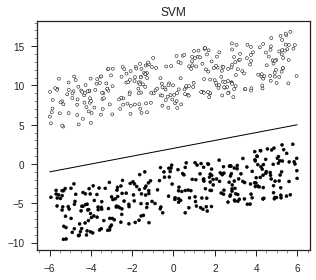

In [177]:
X0, Y0 = gendataset(noise=0)
lm_line0 = model.LinearModel(np.array([-2., -0.5, 1.]))
draw_map(lm_line0, X0, Y0, "SVM")
# plt.xlim(-5,5)
# plt.ylim(-20,20)
plt.savefig('fig/linear_svm.png')
plt.show()

In [377]:
q = 0.9
Q = 100 * q/(1+q)
X, Y = gendataset(q=q)

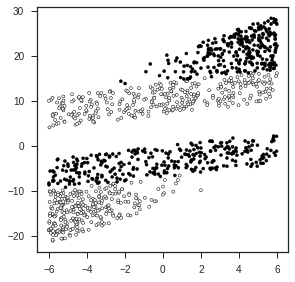

In [378]:
plt.figure(figsize=(4.5,4.5))
plt.scatter(X[:,0], X[:,1], s=9, c=Y, cmap=plt.cm.gray, edgecolors='k', linewidth=0.5)
plt.show()

In [379]:
linmod0 = model.LinearModel(2)
linmod0.init_param()

In [380]:
loss_func0 = loss.MarginLoss(func.Hinge(1.0))
reg0 = regular.Square()
er0 = erisk(X, Y, linmod0, loss_func0, regular=None, tau=0.01)
fg0 = erm_fg(er0, h=0.5, tol=1.0e-7, n_iter=5000, verbose=1)

K=1078 param=[-0.02771828 -0.26095477  0.00292439]


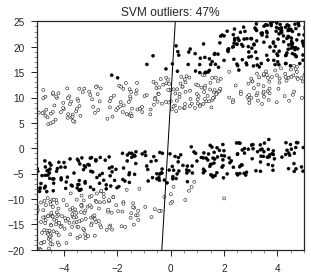

In [381]:
draw_map(linmod0, X, Y, "SVM outliers: %.0f%%" % Q)
plt.xlim(-5,5)
plt.ylim(-20,25)
plt.savefig('fig/linear_svm_1_%.0f.eps' % Q)
plt.show()

In [382]:
linmod1 = model.LinearModel(2)
linmod1.init_param(random=1)

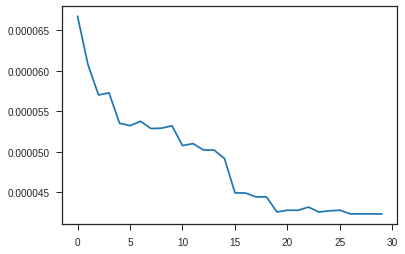

In [383]:
loss_func2 = loss.MarginLoss(func.Hinge(1.0))
alpha = 0.99-q
reg2 = regular.Square()
er2 = erisk(X, Y, linmod1, loss_func2, regular=reg2, tau=0.001)
fg2 = fg(er2, h=0.1, tol=1.0e-8, n_iter=5000)
avg2 = averager_it(func.QuantileFunc(alpha, func.Sqrt(0.001)))
wg2 = weights.WMWeights(avg2, er2)
alg = erm_irgd(fg2, wg2, n_iter=51, tol=1.0e-9, verbose=0)

plt.plot(alg.lvals)
plt.show()

<Figure size 180x180 with 0 Axes>

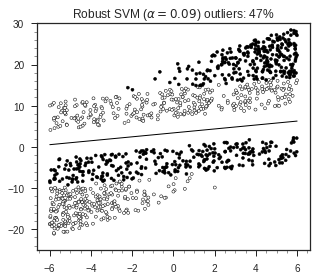

In [384]:
plt.figure(figsize=(2.5,2.5))
draw_map(linmod1, X, Y, r"Robust SVM ($\alpha=%.2f$) outliers: %.0f%%" % (alpha, Q))
plt.savefig(r"fig/rob_linear_svm_2_%.0f.eps" % Q)
plt.ylim(-25,30)
plt.show()

In [267]:
def plot_log(d):
    plt.figure(figsize=(15,4))
    m = len(d)
    i = 1
    for key, vals in sorted(d.items()):
        plt.subplot(1, m, i)
        k_range, u_seq = zip(*enumerate(d[key]))
        plt.plot(k_range, np.abs(u_seq), marker='s', markersize=3)
        plt.grid(1)
        plt.title(key)
        plt.minorticks_on()
        i += 1
        plt.tight_layout()
    plt.show()
    
#plot_log(d)

In [21]:
def draw_map2(X, Y, title, lines):
    plt.figure(figsize=(4.5,4.))
    plt.title(title)
    plt.minorticks_on()
    X1, X2 = X[:,0], X[:,1]
    plt.scatter(X1, X2, c=Y, s=25, cmap=plt.cm.gray, edgecolors='k', linewidth=1)
    x1_min, x1_max = X1.min(), X1.max()
    x2_min, x2_max = X2.min(), X2.max()
    for lm_line, style, label in lines:
        y1_min = get_y(lm_line, x1_min)
        y1_max = get_y(lm_line, x1_max)
        plt.plot([x1_min, x1_max], [y1_min, y1_max], color='k', linestyle=style, label=label)

    plt.ylim(-25,30)
    plt.tight_layout()
    plt.legend(loc='best')


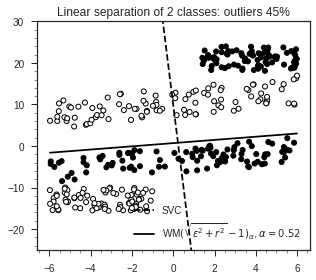

In [22]:
draw_map2(X, Y, r'Linear separation of 2 classes: outliers 45%',
         [(linmod0, '--', 'SVC'), (linmod1, '-', r'WM$(\sqrt{\varepsilon^2+r^2}-1)_\alpha$, $\alpha=0.52$')])
plt.savefig('fig/rob_linear_svm.png')
plt.show()